## Graph Hot Spots Conjecture: Experiments
Arya Maheshwari

Testing graph hot spots conjecture on different examples of graphs and to come up with possible conditions for which conjecture could hold (combinations of planarity, convexity, etc) 

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

### A. Step by step definition of testing procedure

#### 1a. Generate graphs
<font color='purple'> Key part of project: </font> Testing wide variety of graphs, algorithmically/programmatically <font color='red'> (TBD) </font>
<br> - checking convexity examples (convex, strictly convex)
<br> - checking planarity examples

In [2]:
# generate some test graph for now

# G = nx.random_powerlaw_tree(15)
G = nx.grid_2d_graph(5, 10)

node_list = list(G.nodes)

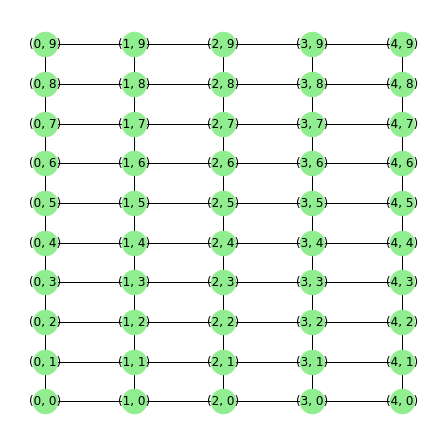

In [3]:
# FOR GRID GRAPH
plt.figure(figsize=(6,6))

pos = {(x,y):(x,y) for x,y in G.nodes()}
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=600)

#### 1b. Check planarity

In [4]:
is_planar, P = nx.check_planarity(G)
print(is_planar)

True


#### 2. Compute boundary of graph
Brute-force algorithm based on $\partial G$ as defined in https://arxiv.org/pdf/2201.03489.pdf:

In [5]:
def compute_boundary(G):
    '''
    Returns list of nodes in G that are in the boundary.
    '''
    # compute shortest path lengths between all vertices
    path_dist = dict(nx.all_pairs_shortest_path_length(G))

    boundary = []
    for u in list(G.nodes): 
        for v in list(G.nodes): # test all v for witness of u as boundary vertex
            dsum = 0
            for w in G.neighbors(u):
                dsum += path_dist[w][v] # compute sum of distances from v to neighbors of u (= w)
            if(path_dist[u][v] > dsum/len(G[u])):
                boundary.append(u)
                break # move on to next vertex to test for boundary
    
    return boundary

In [6]:
boundary = compute_boundary(G)
bound_set = set(boundary)

#### 2b. Check (strict) convexity

In [7]:
def is_convex(G, bound_set, strict=False):
    apsp = dict(nx.all_pairs_shortest_path(G))
    for u in list(G.nodes):
        if (u in bound_set) and not strict: 
            continue
        for v in list(G.nodes):
            if (v in bound_set) and not strict: 
                continue
            for path_node in apsp[u][v]:
                if (path_node != u and path_node != v and path_node in bound_set):
                    return False
    return True

In [8]:
print(is_convex(G, bound_set))
print(is_convex(G, bound_set, strict=True))

True
False


#### 3. Compute second-smallest eigenfunction $\phi_2$
Directly from networkx fiedler_vector method

In [9]:
phi2 = nx.fiedler_vector(G, method='tracemin_lu')
phi2

array([-0.19753767, -0.17820131, -0.14142136, -0.0907981 , -0.03128689,
        0.03128689,  0.0907981 ,  0.14142136,  0.1782013 ,  0.19753767,
       -0.19753767, -0.17820131, -0.14142136, -0.0907981 , -0.03128689,
        0.03128689,  0.0907981 ,  0.14142136,  0.1782013 ,  0.19753767,
       -0.19753767, -0.1782013 , -0.14142136, -0.0907981 , -0.03128689,
        0.03128689,  0.0907981 ,  0.14142136,  0.1782013 ,  0.19753767,
       -0.19753767, -0.1782013 , -0.14142136, -0.0907981 , -0.03128689,
        0.03128689,  0.0907981 ,  0.14142136,  0.17820131,  0.19753767,
       -0.19753767, -0.1782013 , -0.14142136, -0.0907981 , -0.03128689,
        0.03128689,  0.0907981 ,  0.14142136,  0.17820131,  0.19753767])

#### 4. Check conjecture: are smallest and largest values on boundary?

In [10]:
min_node = node_list[list(phi2).index(min(phi2))]
max_node = node_list[list(phi2).index(max(phi2))]

print("Maximum node in Fiedler vector:",max_node)
print("On boundary?", (max_node in bound_set))
print("Minimum node in Fiedler vector:",min_node)
print("On boundary?", (min_node in bound_set))


Maximum node in Fiedler vector: (4, 9)
On boundary? True
Minimum node in Fiedler vector: (0, 0)
On boundary? True


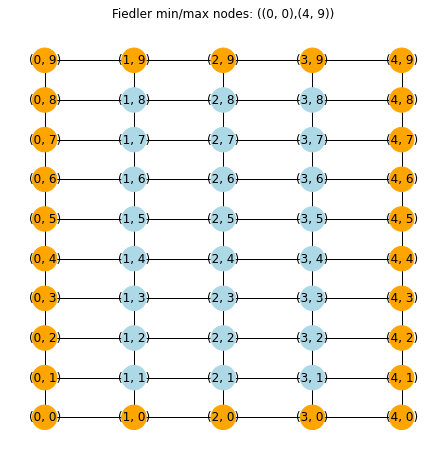

In [11]:
# visualize obtained boundary in graph drawing
plt.figure(figsize=(6,6))
colors = ['orange' if n in bound_set else 'lightblue' for n in list(G.nodes)]
pos = {(x,y):(x,y) for x,y in G.nodes()}

nx.draw(G, node_color=colors, pos=pos, with_labels=True, node_size=600)

plt.title("Fiedler min/max nodes: ("+str(min_node)+","+str(max_node)+")")
plt.show()

---

### B. Run testing procedure for specific graph types

Functions defined in or relevant from (A) that will be used: nx.is_planar, boundary, is_convex, nx.fiedler_vector

In [12]:
def check_conjecture(G, pos=None, verbose=True, plot=True):
    '''
    Returns: (1)min Fiedler node, (2) max Fiedler node, (3) is planar?, (4) is convex?, (5) is strictly convex? (6) boundary set
    '''
    node_list = list(G.nodes)
    
    bound = compute_boundary(G)
    bound_set = set(bound)
#     print('boundary computed')
    
    is_plan, P = nx.check_planarity(G)
    is_conv = is_convex(G, bound_set)
    is_strict_conv = is_convex(G, bound_set, strict=True)
#     print('conditions checked')
    
    phi2 = nx.fiedler_vector(G, method='tracemin_lu')
#     print('fiedler computed')
    
    min_node = node_list[list(phi2).index(min(phi2))]
    max_node = node_list[list(phi2).index(max(phi2))]
    
    if verbose:
        print("Planar?", is_plan)
        print("Convex?", is_conv)
        print("Strictly convex?", is_strict_conv)
        print()
        print("Maximum node in Fiedler vector:",max_node)
        print("On boundary?", (max_node in bound_set))
        print("Minimum node in Fiedler vector:",min_node)
        print("On boundary?", (min_node in bound_set))
    
    if plot:
        plt.figure(figsize=(6,6))
        colors = ['orange' if n in bound_set else 'lightblue' for n in list(G.nodes)]

        if pos is not None:  
            nx.draw(G, node_color=colors, pos=pos, with_labels=True, node_size=600)
        else:
            nx.draw(G, node_color=colors, with_labels=True, node_size=600)

        plt.title("Fiedler min/max nodes: ("+str(min_node)+","+str(max_node)+")")
        plt.show()
    
    return min_node, max_node, is_plan, is_conv, is_strict_conv, bound_set

#### 1. Grid graph tests 

Planar? True
Convex? True
Strictly convex? False

Maximum node in Fiedler vector: (6, 4)
On boundary? True
Minimum node in Fiedler vector: (0, 0)
On boundary? True


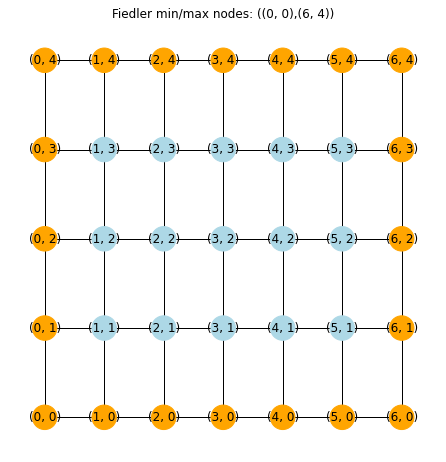

In [13]:
# Create m x n 2D grid/lattice graph
m = 7
n = 5

G = nx.grid_2d_graph(m, n)
pos = {(x,y):(x,y) for x,y in G.nodes()}
min_node, max_node, is_plan, is_conv, is_strict_conv, bound_set = check_conjecture(G, pos);

#### 2. Random power-law tree tests

Planar? True
Convex? True
Strictly convex? True

Maximum node in Fiedler vector: 11
On boundary? True
Minimum node in Fiedler vector: 0
On boundary? True


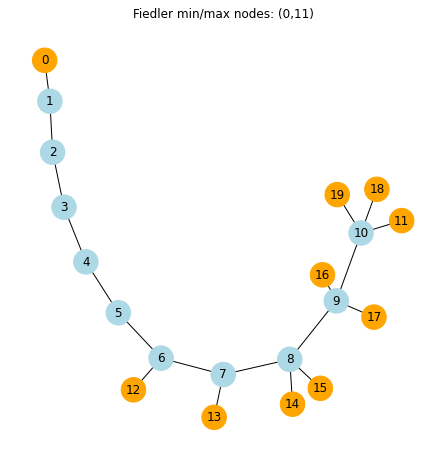

In [14]:
n = 20

G = nx.random_powerlaw_tree(n)
min_node, max_node, is_plan, is_conv, is_strict_conv, bound_set = check_conjecture(G);

### C. Generate results for suite of random graphs 

1. using connected Erdos-Renyi random graphs via repeated generation, and then just testing for planar, conv, strict_conv?

In [15]:
n = 30
p = 0.05
test_count = 100

graphs = []
conv = []
strict_conv = []
planar = []
conjecture_res = []

for i in range(test_count):
    G = nx.gnp_random_graph(n, p)
    while not nx.is_connected(G):
        G = nx.gnp_random_graph(n, p)
    
    min_node, max_node, is_plan, is_conv, is_strict_conv, bound_set = check_conjecture(G, verbose=False, plot=False);
#     print('computations done')
    
    graphs.append(G)
    conv.append(is_conv)
    strict_conv.append(is_strict_conv)
    planar.append(is_plan)
    conjecture_res.append((min_node in bound_set and max_node in bound_set))
    
    if(i % 10 == 0):
        print("Test", i, "done")

Test 0 done
Test 10 done
Test 20 done
Test 30 done
Test 40 done
Test 50 done
Test 60 done
Test 70 done
Test 80 done
Test 90 done


In [16]:
# counts number of "True"s in each list
print(sum(conjecture_res))
print(sum(planar))
print(sum(conv))
print(sum(strict_conv))

100
81
12
3


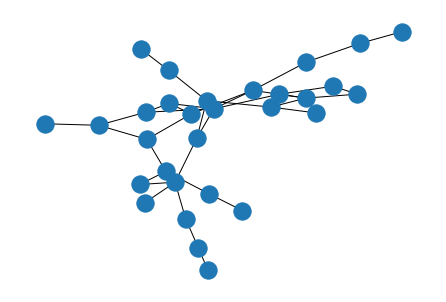

In [17]:
nx.draw(graphs[1])